# MPC - CasADi
## MPC for Pendulum
https://web.casadi.org/

In [11]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

from casadi import *
#from pylab import plot, step, figure, legend, show, spy

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

opts1 = {"expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-2, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

Running Python: 3.8.16


In [12]:
class Model():
    def __init__ (self):
        self.opti = None
        self.params = None
        self.sol = None
        self.Umax = 500 # system params
        self.omega_n2 = (5.3761)**2
        self.damping = 2*0.0485*5.3761
        self.gain =  40/100/57.3 # measured
        self.A = np.array([[0.0, 1.0],[-self.omega_n2, -2*0.0485*5.3761]])
        self.B = np.array([[0.0,self.gain*self.omega_n2]])

#Fd = 0.8546
#wd = 5.3697
#zeta = 0.0485
#wn = 5.3761
       
Ruu = 1e-1
Rzz = np.array([[1000, 0],[0, 1]])   # performance variable penalty

# MPC
N = 5 # MPC steps
Fs = 25 #Hz
Ts = 1/Fs
Tf = N*Ts # MPC plan horizon
t_plan = np.linspace(0, Tf, N+1) # MPC plan time
print('Ts:           ',Ts)
print('Plan Horizon: ',Tf)

# sim
Tfsim = 20
delT_sim = Ts             # sim Ts
t_prop = np.array([0,delT_sim]) # prop time
Npts = Tfsim//delT_sim     # number of sim pts

Ts:            0.04
Plan Horizon:  0.2


In [13]:
def smootherstep(edge0, edge1, x): 
    # Scale, and clamp x to 0..1 range
    x = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    # Evaluate polynomial
    return x * x * x * (x * (x * 6 - 15) + 10)

# ODE compute response to an input stream given by U
def fun(t,x,u,Tmax): # sim model
    # dxdt = A@x + Bu*u(t)
    if t > Tmax:
        t = Tmax
    u = sat(u(t),-Pend.Umax,Pend.Umax)
    return np.array([x[1], -Pend.omega_n2 *np.sin(x[0]) -Pend.damping*x[1] + Pend.B[:,1][0] * u])

def deriv(x,u): #MPC design model
        #return vertcat(x[1], -Pend.omega_n2 *x[0] -Pend.damping*x[1] + Pend.B[:,1][0] * u) 
        #return vertcat(x[1], -Pend.omega_n2 *np.sin(x[0]) -Pend.damping*x[1] + Pend.B[:,1][0] * u) 
        return vertcat(x[1], -Pend.omega_n2 *np.sin(x[0]) + Pend.B[:,1][0] * u) 

def create_opti(Pend):
    opti = Opti() # Optimization problem

    # ---- decision variables ---------
    cX = opti.variable(2,N+1) # state trajectory
    cU = opti.variable(1,N)   # control trajectory (throttle)
    cx0 = cX[0,:]
    cx1 = cX[1,:]
    cUdiff = cU[0,:-1] - cU[0,1:]

    # ---- dynamic constraints - dx/dt = f(x,u)
    f = lambda x,u: deriv(x,u)

    dt = Tf/N # length of a control interval
    for k in range(N): # loop over control intervals
        # Runge-Kutta 4 integration
        k1 = f(cX[:,k],         cU[:,k])
        k2 = f(cX[:,k]+dt/2*k1, cU[:,k])
        k3 = f(cX[:,k]+dt/2*k2, cU[:,k])
        k4 = f(cX[:,k]+dt*k3,   cU[:,k])
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps

    # ---- boundary conditions --------
    p = opti.parameter(1,2)
    opti.subject_to(opti.bounded(-Pend.Umax,cU,Pend.Umax)) # control is limited

    opti.subject_to(cx0[0] == p[0])   # start at position 0 ...
    opti.subject_to(cx1[0] == p[1]) # ... from stand-still 
    
    # ---- objective          ---------
    #opti.minimize(Rzz[0,0]*dot(cx0,cx0) + Rzz[1,1]*dot(cx1,cx1) + Ruu*dot(cUdiff,cUdiff)) 
    Pend.opti = opti
    Pend.params = p, cX, cUdiff, cU
    return Pend 

def min_casadi(X0,Ref,Uold,Pend):
    if Pend.opti is None:
        #tic = time.time()
        Pend = create_opti(Pend)
        p, cX, cUdiff,_ = Pend.params
        Pend.opti.solver('ipopt',opts0) # set numerical backend
        #print(f"set up {time.time() - tic:.3f}")
    else:
        p, cX, cUdiff, cU = Pend.params
        Pend.opti.set_initial(Pend.sol.value_variables())
        Pend.opti.solver('ipopt',opts1) # set numerical backend
        Pend.opti.set_initial(cU, Uold)

    Pend.opti.set_value(p[0],X0[0])
    Pend.opti.set_value(p[1],X0[1])

    # ---- objective          ---------
    Refc = MX(Ref.reshape(1,N+1))
    Z = Refc - cX[0,:]

    # ---- objective          ---------
    Pend.opti.minimize(Rzz[0,0]*dot(Z,Z) + Rzz[1,1]*dot(cX[1,:],cX[1,:]) + Ruu*dot(cUdiff,cUdiff)) 

    # ---- initial values for solver ---
    #tic = time.time()
    Pend.sol = Pend.opti.solve()   # actual solve
    #print(f"compute {time.time() - tic:.3f}")
    return Pend #sol.value(cU), sol.value(cx0)[1], sol.stats()['success']

In [14]:
# more on where this conversion comes from later in the course
def DiscretizeQ(A,Bw,vel_std,Bu,dt):
    # find equivalent discrete noise matrix Qd
    Nx,_ = A.shape
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@Bw.T*vel_std**2
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = scipy.linalg.expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Qd = Ad@CC[0:Nx,Nx:2*Nx]
    
    Nu = 1 # anoyingly hard to compute
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu.T
    CC = scipy.linalg.expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]

    return Qd, Ad, Bd 

In [15]:
Pend = Model()

x0 = np.array([[.1],[.1]])           # just pick an initial cond 
x = copy.deepcopy(x0)
xss = copy.deepcopy(x0)
xsat = copy.deepcopy(x0)

Tstore =[]
U = np.zeros(N)
Ustore = []
Ussstore = []
Uss_satstore = []
prev_time = time.time()

_ , Ad, Bd = DiscretizeQ(Pend.A,Pend.B,1,Pend.B,Ts)
# discrete steady state LQR
Pss = la.solve_discrete_are(Ad, Bd, Rzz, Ruu)
Kss = Bd.T@Pss@Ad/(Ruu+Bd.T@Pss@Bd)

Xs = []
Xss_s = []
Xss_sat = []

Acl = Ad-Bd@Kss
ev,_=np.linalg.eig(Acl)
print(np.abs(ev))
R_scale = 1/(np.array([1,0])@np.linalg.inv(np.eye(2) - Acl)@Bd)
print(R_scale)

def Reference(t):
    return np.pi*(smootherstep(1,1.1,t) - smootherstep(3,3.1,t))

for k in np.arange(Npts):
    t_elapsed = k*delT_sim
    Uold = np.append(U[1:],U[-1]) # shift and append guess of 0 to end   
    tic = time.time()
    Pend = min_casadi(x,Reference(t_elapsed + t_plan),Uold,Pend)
    _,_,_,cU  = Pend.params
    U = Pend.sol.value(cU)
    Tstore = np.append(Tstore,time.time() - tic)

    Uss = R_scale * Reference(t_elapsed) - Kss@xss # steady state gains
    Usat = np.clip(R_scale * Reference(t_elapsed) - Kss@xsat,-Pend.Umax,Pend.Umax) # saturated control inputs
    
    Xs = np.append(copy.deepcopy(Xs),copy.deepcopy(x))
    Xss_s = np.append(Xss_s,copy.deepcopy(xss))
    Xss_sat = np.append(Xss_sat,copy.deepcopy(xsat))
    
    if 1:
        uprop = interp1d(x = t_prop, y = U[0:2], kind='zero')
        prop = solve_ivp(fun, [0, Ts], x.reshape(2,), t_eval=t_prop, args=(uprop,max(t_prop), ))
        x = prop.y[:,-1]
    else:
        x = Ad@x + Bd*np.clip(U[0],-Pend.Umax,Pend.Umax)              # MPC
    xss = Ad@xss + Bd*Uss           # SS LQR 
    xsat = Ad@xsat + Bd*Usat        # saturated LQR

    Ustore = np.append(Ustore,np.clip(U[0],-Pend.Umax,Pend.Umax))
    Ussstore = np.append(Ussstore,Uss)
    Uss_satstore = np.append(Uss_satstore,Usat)
    prev_time = time.time()
    if (k%10 == 0):
        print(f'{k/Npts:.2f}',end=' ')

[ 0.9296  0.9296]
[ 164.1089]
         but the previous value is set to disallow clobbering.
         The setting will remain as: "linear_solver ma27"
         but the previous value is set to disallow clobbering.
         The setting will remain as: "tol 0.01"
0.00 0.02 0.04 0.06 0.08 0.10 0.12 0.14 0.16 0.18 0.20 0.22 0.24 0.26 0.28 0.30 0.32 0.34 0.36 0.38 0.40 0.42 0.44 0.46 0.48 0.50 0.52 0.54 0.56 0.58 0.60 0.62 0.64 0.66 0.68 0.70 0.72 0.74 0.76 0.78 0.80 0.82 0.84 0.86 0.88 0.90 0.92 0.94 0.96 0.98 

In [16]:
t = np.arange(0,Tfsim,Ts)[0:int(Npts)]
if (len(t) != Npts):
    t = np.arange(0,Tfsim+Ts,Ts)[0:int(Npts)]

usim = interp1d(x = t, y = Ustore, kind='zero')
sim = solve_ivp(fun, [0, max(t)], x0.reshape(2,), t_eval=t, args=(usim,max(t), ))

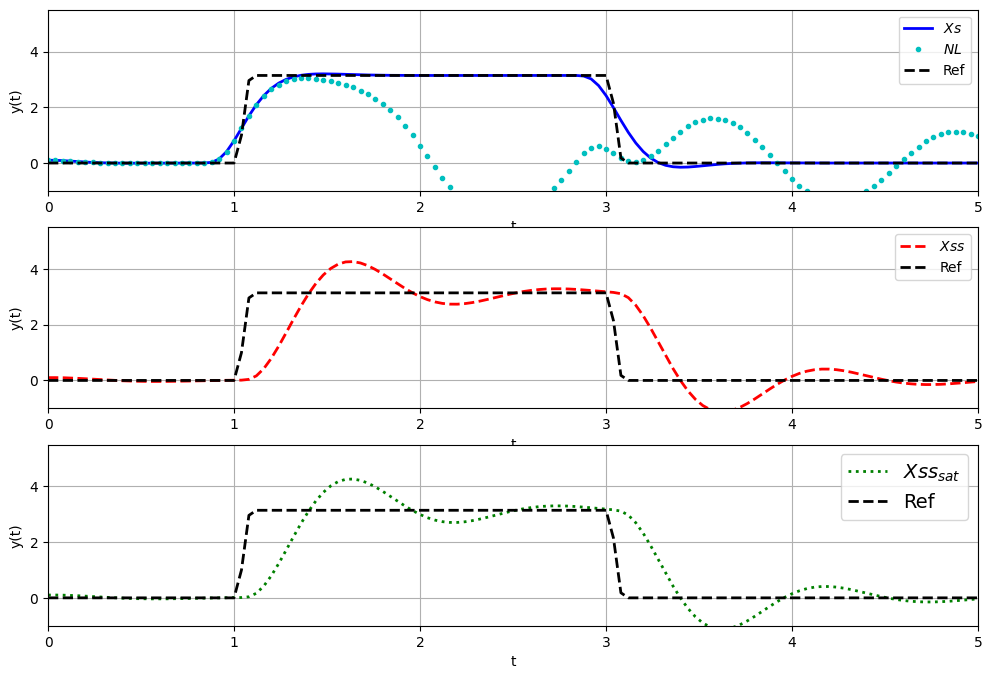

In [17]:
fig,axs = plt.subplots(3,figsize = (12,8))
axs[0].plot(t,Xs[0::2],'b',label='$Xs$')
axs[1].plot(t,Xss_s[0::2],'r--',label='$Xss$')
axs[2].plot(t,Xss_sat[0::2],'g:',label='$Xss_{sat}$')
axs[0].plot(t,sim.y[0,:],'c.',label='$NL$')
for ii in range(3):
    axs[ii].plot(t,Reference(t),'k--',label='Ref')
    axs[ii].set_xlabel('t')
    axs[ii].legend()
    axs[ii].set_ylabel('y(t)')
    axs[ii].set_xlim([0,max(t)])
    axs[ii].set_xlim([0,5])
    axs[ii].set_ylim([-1,5.5])

plt.legend(fontsize=14)
plt.show()

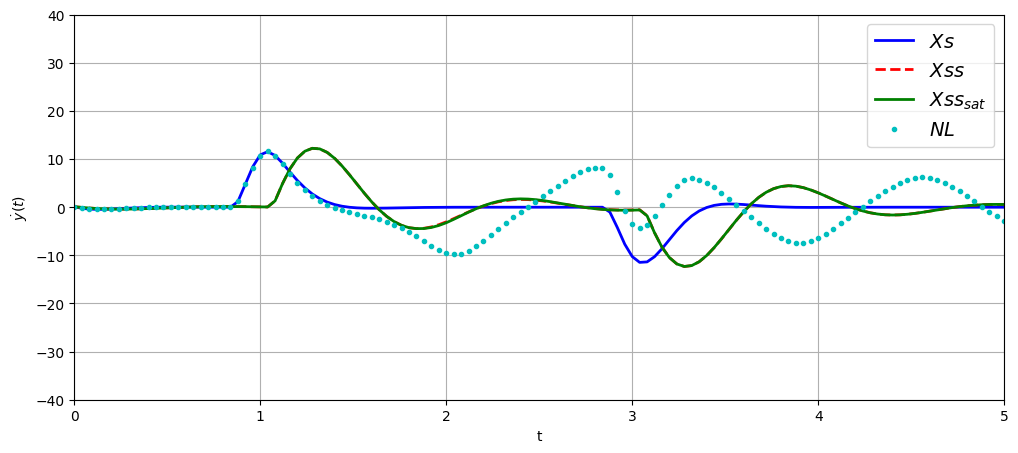

In [18]:
plt.figure(figsize = (12,5))
plt.plot(t,Xs[1::2],'b',label='$Xs$')
plt.plot(t,Xss_s[1::2],'r--',label='$Xss$')
plt.plot(t,Xss_sat[1::2],'g-',label='$Xss_{sat}$')
plt.plot(t,sim.y[1,:],'c.',label='$NL$')
plt.xlabel('t')
plt.legend()
plt.ylabel('$\dot y(t)$')
plt.xlim([0,max(t)])
plt.xlim([0,5])
plt.ylim([-40,40])
plt.legend(fontsize=14)
plt.show()

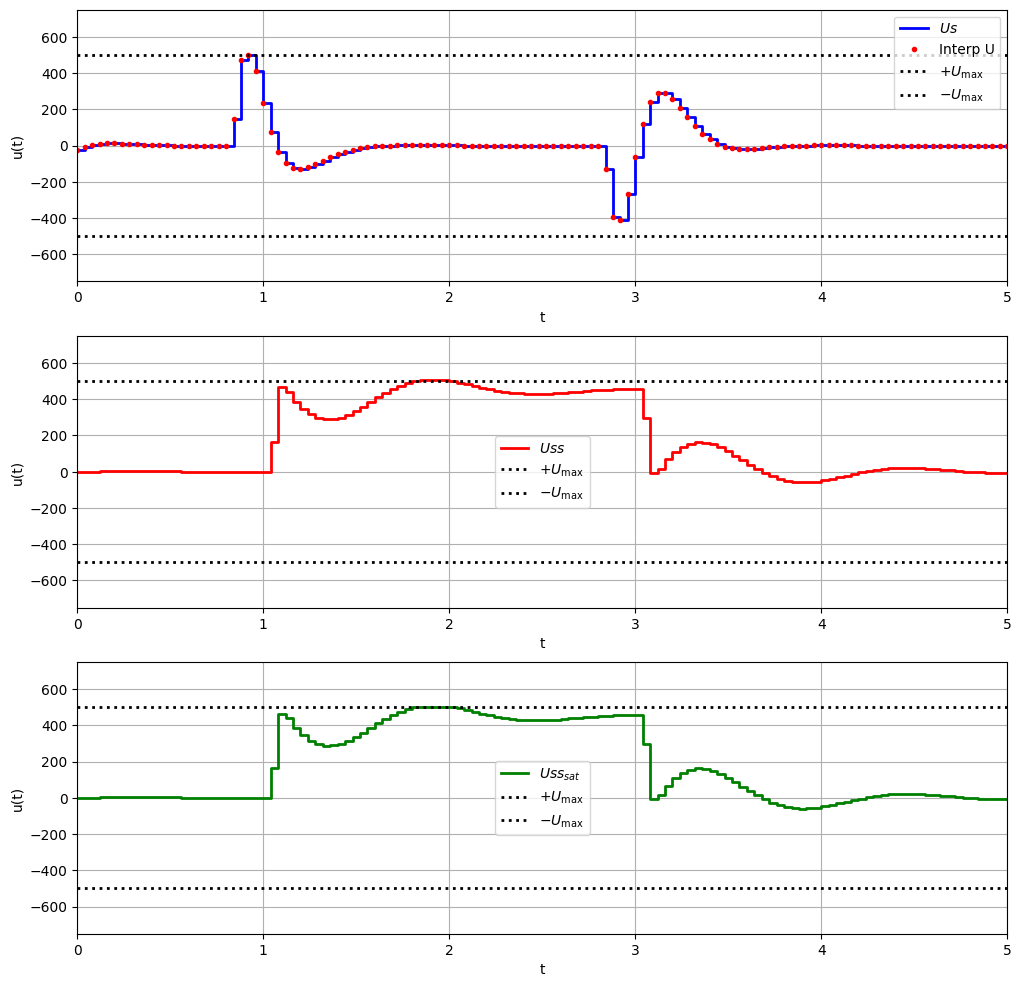

In [19]:
fig,axs = plt.subplots(3,figsize = (12,12))
axs[0].step(t,Ustore[0::1],'b',label='$Us$',where='post')
axs[0].step(t,usim(t),'r.',label='Interp U',where='post')
axs[1].step(t,Ussstore[0::1],'r-',label='$Uss$',where='post')
axs[2].step(t,Uss_satstore[0::1],'g-',label='$Uss_{sat}$',where='post')
plt.legend(fontsize=20)
for ii in range(3):
    axs[ii].plot([0 ,max(t)], [Pend.Umax, Pend.Umax],'k:',label='$+U_\max$')
    axs[ii].plot([0 ,max(t)], [-Pend.Umax, -Pend.Umax],'k:',label='$-U_\max$')
    axs[ii].set_xlabel('t')
    axs[ii].legend()
    axs[ii].set_ylabel('u(t)')
    axs[ii].set_ylim([-Pend.Umax*1.5,Pend.Umax*1.5])
    axs[ii].set_xlim([0,max(t)])
    axs[ii].set_xlim([0,5])
plt.show()

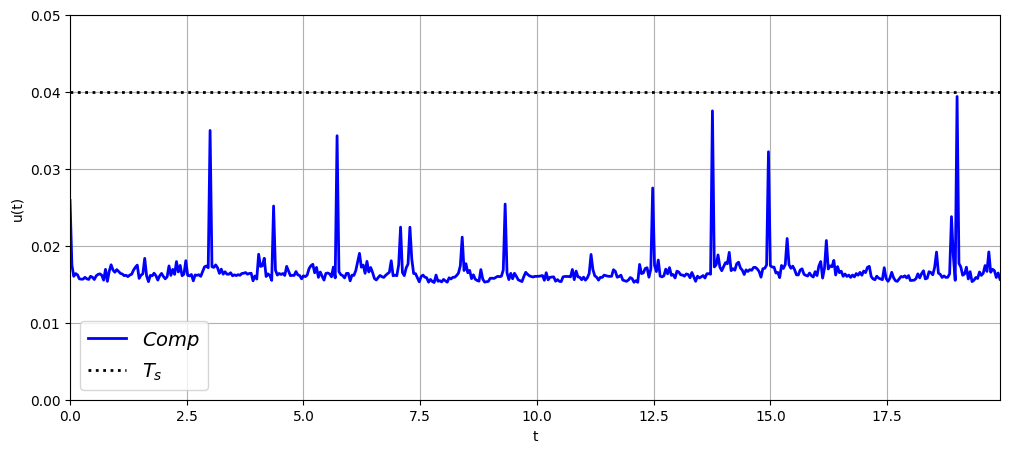

In [20]:
plt.figure(figsize = (12,5))
plt.plot(t,Tstore[0::1],'b',label='$Comp$')
plt.plot([0 ,max(t)], [Ts, Ts],'k:',label='$T_s$')
plt.xlabel('t')
plt.legend()
plt.ylabel('u(t)')
plt.ylim([0,1.25*Ts])
plt.legend(fontsize=14)
plt.xlim([0,max(t)])
plt.show()